In [1]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# surpress warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
def get_files(folder):
    directory = "data/%s/" % folder
    return glob.glob(directory + "*.json")

def load_dict(file):
    d = None
    with open(file.replace("\\", "/")) as file:
        d = json.load(file)
    return d

def load_df(folder):

    files = get_files(folder)
    get_date = lambda file_name: file_name[len(folder) + 6:-15]

    if folder in ["youtube_top100", "radio3fm_megahit", "radio538_alarmschijf"]:

        keys = ['viewCount',
                'likeCount',
                'dislikeCount',
                'commentCount',
                #'favoriteCount'
                ]
                
        df = []
        for year_file in files:
            year_data = load_dict(year_file)
            for song_data in year_data:
                row = [get_date(year_file), song_data['snippet']['title']]
                row.extend([song_data['statistics'][key] for key in keys])
                df.append(row)

        columns = ['date', 'songName']
        columns.extend(keys)
        df = pd.DataFrame(df, columns = columns)

        for column in set(df.columns).difference({'date', 'songName'}):
            df[column] = df[column].astype('double')

        df['likeDislikeDiff']  = df['likeCount'] - df['dislikeCount']
        df['likeDislikeTotal'] = df['likeCount'] + df['dislikeCount']

        df.index = pd.to_datetime(df['date'], format='%Y%m%d')
            
        return df
    if folder == "spotify_top100":        

        # missing artist name

        keys = ['name',
                'popularity']

        df = []
        for year_file in files:
            year_data = load_dict(year_file)
            for track_data in year_data['tracks']['items']:
                row = [get_date(year_file)]
                row.extend(track_data['track'][key] for key in keys)
                df.append(row)
        
        columns = ['date']
        columns.extend(keys)
        df = pd.DataFrame(df, columns = columns)
        
        df.index = pd.to_datetime(df['date'], format='%Y%m%d')

        return df
    else:
        raise AssertionError("Function not implemented for the folder \"%s\"" % folder)

def get_song_dfs(df, n=None, seed=37):
    """Get a list of dataframes. Each dataframe represents one song

    Create the dataframe with the song name and then interpolate to fill
    empty dates

    Args:
        df (DataFrame): Original dataframe. Should be created from Youtube format
        n (int): Number of song dfs to create and return. Default value in None,
            all the possible songs are used to create song dfs when n is None.
    """
    np.random.seed(seed)

    songs = df['songName'].unique()
    if n:
        songs = np.random.choice(songs, n)
    song_dfs = []
    for song_name in songs:
        song_df = df[df['songName'] == song_name]
        song_df = song_df.resample('D').asfreq()
        song_df = song_df.interpolate()
        song_dfs.append(song_df)
    return song_dfs

get_line_method = lambda p: lambda x: p[0] * x + p[1]

def get_view_growth(viewCount):
    return (viewCount.shift(-1) - viewCount).dropna()

def get_z_hat_df(series):
    df = pd.DataFrame({'z':series, 'z_hat':series.shift(-1)})
    df = df.dropna()
    return df

def apply_p(p, series):
    l = len(p)
    sum = (series ** (l-1)) * p[0]
    for i in range(l-1):
        sum += (series ** (l-i-2)) * p [i+1]
    return sum

## Youtube

In [3]:
youtube_df = load_df("youtube_top100")
youtube_df.head(5)

,date,songName,viewCount,likeCount,dislikeCount,commentCount,likeDislikeDiff,likeDislikeTotal
date,,,,,,,,
2015-11-09,20151109,Adele - Hello,297130779.0,4093202.0,101335.0,291458.0,3991867.0,4194537.0
2015-11-09,20151109,Justin Bieber - Sorry (Dance Video),92743480.0,1355977.0,71243.0,104720.0,1284734.0,1427220.0
2015-11-09,20151109,Drake - Hotline Bling,57075104.0,672355.0,60531.0,72120.0,611824.0,732886.0
2015-11-09,20151109,Justin Bieber - What Do You Mean?,276365510.0,2310400.0,254413.0,189319.0,2055987.0,2564813.0
2015-11-09,20151109,Shawn Mendes - Stitches (Official Video),72148555.0,906781.0,14618.0,57624.0,892163.0,921399.0


In [4]:
last_day_df = youtube_df[youtube_df['date'] == youtube_df['date'].max()]
last_day_df = last_day_df.sort_values(by='viewCount', ascending=False)
last_day_df.head(5)

,date,songName,viewCount,likeCount,dislikeCount,commentCount,likeDislikeDiff,likeDislikeTotal
date,,,,,,,,
2016-11-28,20161128,Wiz Khalifa - See You Again ft. Charlie Puth [...,2.215694e+09,12313574.0,372922.0,855945.0,11940652.0,12686496.0
2016-11-28,20161128,Justin Bieber - Sorry (PURPOSE : The Movement),2.024405e+09,7245356.0,892614.0,603157.0,6352742.0,8137970.0
2016-11-28,20161128,Mark Ronson - Uptown Funk ft. Bruno Mars,1.998288e+09,7291862.0,412835.0,341571.0,6879027.0,7704697.0
2016-11-28,20161128,Adele - Hello,1.797022e+09,10930604.0,576234.0,758373.0,10354370.0,11506838.0
2016-11-28,20161128,Major Lazer & DJ Snake - Lean On (feat. MØ) (O...,1.748944e+09,6334360.0,294245.0,281826.0,6040115.0,6628605.0


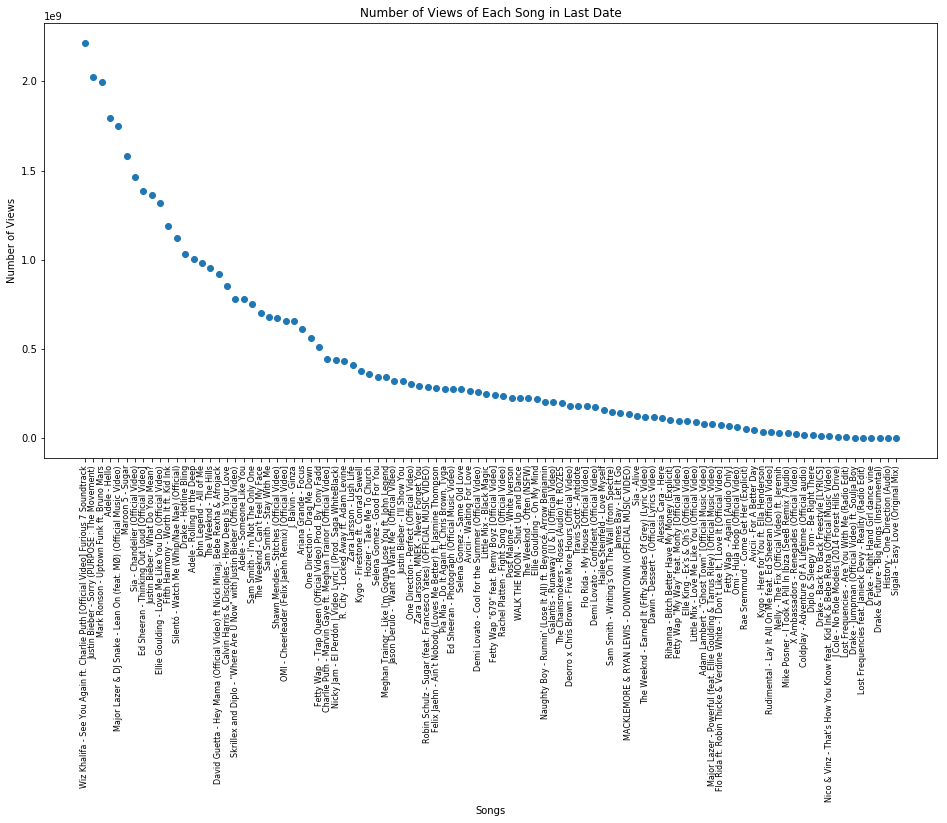

In [5]:
plt.figure(figsize=(16,8))
plt.scatter(range(last_day_df.shape[0]), 
            last_day_df['viewCount'],
            label="Data Points")
plt.xlabel("Songs")
plt.xticks(range(last_day_df.shape[0]),
           labels = last_day_df['songName'],
           rotation = 90,
           fontsize = 8)
plt.ylabel("Number of Views")

plt.title("Number of Views of Each Song in Last Date")
plt.show()

## Spotify

In [6]:
spotify_df = load_df("spotify_top100")
spotify_df.head(5)

,date,name,popularity
date,,,
2015-11-09,20151109,Hello,97
2015-11-09,20151109,Sorry,98
2015-11-09,20151109,Hotline Bling,96
2015-11-09,20151109,What Do You Mean?,99
2015-11-09,20151109,Stitches,92


In [7]:
last_day_df = spotify_df[spotify_df['date'] == spotify_df['date'].max()]
last_day_df = last_day_df.sort_values(by='popularity', ascending=False)
last_day_df

,date,name,popularity
date,,,
2016-11-28,20161128,Closer,100
2016-11-28,20161128,In the Name of Love,96
2016-11-28,20161128,Starboy,95
2016-11-28,20161128,Let Me Love You,95
2016-11-28,20161128,My Way,95
...,...,...,...
2016-11-28,20161128,Starving,63
2016-11-28,20161128,Last Christmas,51
2016-11-28,20161128,Nothing Without You,44


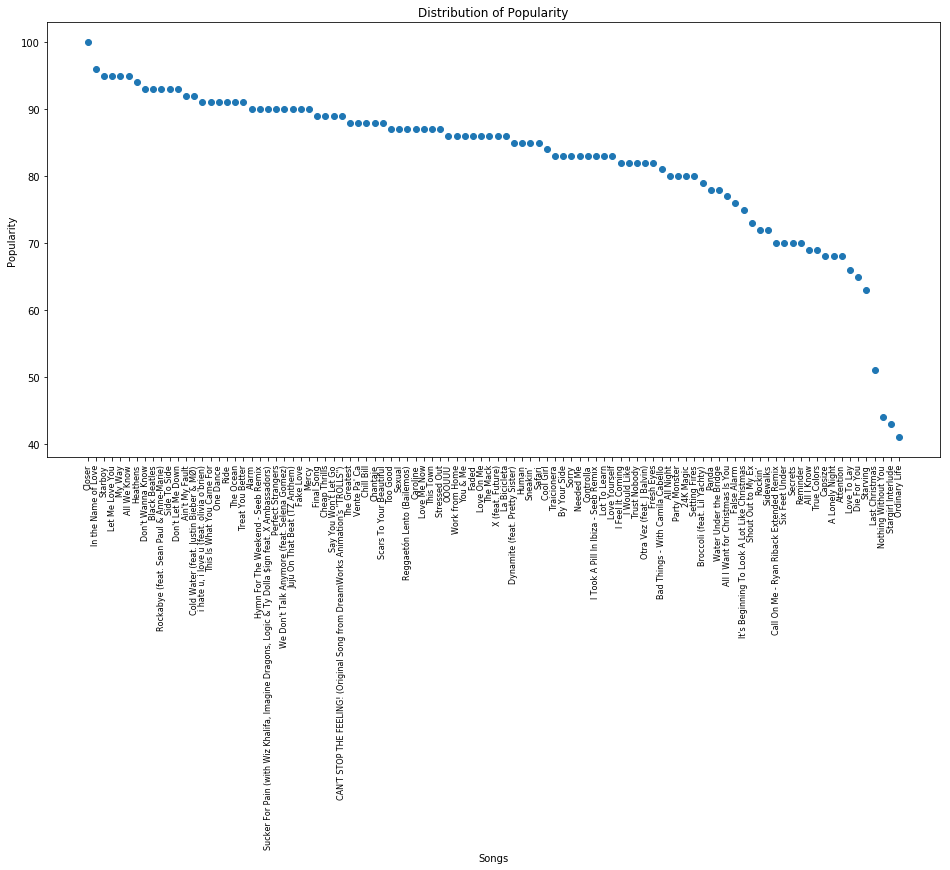

In [8]:
plt.figure(figsize=(16,8))
plt.scatter(range(last_day_df.shape[0]), 
            last_day_df['popularity'],
            label="Data Points")
plt.xlabel("Songs")
plt.xticks(range(last_day_df.shape[0]),
           labels = last_day_df['name'],
           rotation = 90,
           fontsize = 8)
plt.ylabel("Popularity")

plt.title("Distribution of Popularity")
plt.show()